In [1]:
from network import OlshausenField1996Model
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
import scipy.io as sio
import pydeep.misc.io as io
import numpy as numx
from pydeep.preprocessing import ICA, ZCA
import pydeep.misc.visualization as vis

e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\io.py:417: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\io.py:417: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:252: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:345: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:347: SyntaxWarning: "is" with a literal. Did you mean "=="?
e:\Anaconda Revive\lib\site-packages\pydeep-1.2.0-py3.9.egg\pydeep\misc\visualization.py:244: SyntaxWarning: "is" with a literal

In [2]:
torch.__version__
torch.cuda.is_available()

True

(512, 512, 10) (512, 512, 10)
Loaded 256000
torch.Size([256, 1, 9, 9])


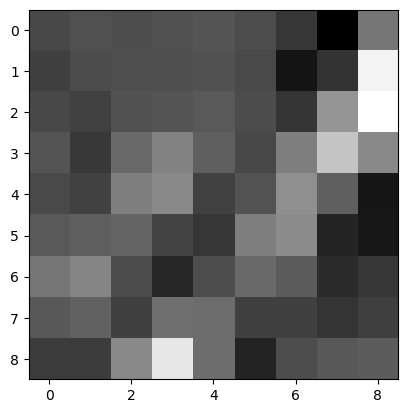

In [3]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mat_images = sio.loadmat('./datasets/IMAGES.mat')
imgs = mat_images['IMAGES']
mat_images_raw = sio.loadmat('./datasets/IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']
print(imgs.shape, imgs_raw.shape)

#data_dir = r"S:\DQRs Order\miniImageNet"
o_imgsize = 84
batch_size = 256
n_iters =500
imgsize = 9
early_stopping = True
n_units = 100
nt_max = 1000

# class FilterSmall:
#     def __init__(self, min_size=(16, 16)):
#         self.min_w, self.min_h = min_size

#     def __call__(self, img: Image.Image):
#         w, h = img.size
#         if w < self.min_w or h < self.min_h:
#             return  img.resize((max(w, self.min_w), max(h, self.min_h))) #stretch to min size
#         return img
class Normalize01():
    def __call__(self, tensor):
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        normalized_tensor = (tensor - min_val) / (max_val - min_val + 1e-8)
        return normalized_tensor
transform = transforms.Compose([
    #FilterSmall(min_size=(imgsize, imgsize)),
    transforms.ToTensor(),
    transforms.RandomCrop(imgsize),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    #transforms.Lambda(lambda x: 0.2989 * x[0:1] + 0.5870 * x[1:2] + 0.1140 * x[2:3])
    #transforms.Lambda(lambda x: x-torch.mean(x))
    #Normalize01()
])

#dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None, repeat_factor=100):
        self.images = images
        self.transform = transform
        self.repeat_factor = repeat_factor
        self.num_images = images.shape[2]

    def __len__(self):
        return self.num_images * self.repeat_factor

    def __getitem__(self, idx):
        img_idx = idx % self.num_images
        img = self.images[:,:,img_idx]
        if self.transform:
            img = self.transform(img)
        return img.to(torch.float32)

dataset = ImageDataset(imgs, transform=transform, repeat_factor=batch_size*100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
print(f"Loaded {len(dataset)}")
images = next(iter(dataloader))
images = images.to(device)

print(images.shape)

plt.imshow(images[0][0].cpu(), cmap='gray')

In [4]:
data_ica = io.load_natural_image_patches('NaturalImage.mat')
print(data_ica.shape)

# Specify image width and height for displaying
width = height = 14

# Use ZCA to whiten the data and train it
# (you could also use PCA whitened=True + unproject for visualization)
zca = ZCA(input_dim=width * height)
zca.train(data=data_ica)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data = zca.project(data_ica)
dataloader_ica = DataLoader(torch.tensor(whitened_data,dtype=torch.float32), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

-> loading data ... 
-> done!
(70000, 196)


In [5]:

eps = 1e-2 # small value which determines convergence
error_list = [] # List to save errors
OlshausenNet = OlshausenField1996Model(num_inputs=imgsize**2, num_units=100, batch_size=batch_size, device=device)


In [ ]:
import os
os.makedirs('patches', exist_ok=True)
patches = []
# Run simulation
for n, imgs in tqdm.tqdm(enumerate(dataloader)):
    # Get the coordinates of the upper left corner of clopping image randomly.
    
    # '''pre-save data generator'''
    # for i in range(imgs.shape[0]):
    #     x = imgs[i].cpu().numpy() 
    #     patches.append(x)

    inputs = imgs.flatten(start_dim=1)  # Flatten images to (batch_size, imgsize*imgsize)
    if inputs.shape[1] != imgsize**2:
        print("Not correct size:", inputs.shape[1], imgsize**2)
        continue  # Skip if image size is not correct
    if inputs.shape[0] != batch_size:
        continue  # Skip if batch size is not correct

    OlshausenNet.initialize_states() # Reset states
    OlshausenNet.normalize_rows() # Normalize weights
    
    # Input an image patch until latent variables are converged 
    r_tm1 = OlshausenNet.r # set previous r (t minus 1)

    for t in range(nt_max):
        # Update r without update weights 
        error, r = OlshausenNet(inputs, training=False)
        dr = r - r_tm1 

        # Compute norm of r
        dr_norm = torch.norm(dr) / (eps + torch.norm(r_tm1))
        r_tm1 = r # update r_tm1
        
        # Check convergence of r, then update weights
        if dr_norm < eps:
            error, r = OlshausenNet(inputs, training=True)
            break
        
        # If failure to convergence, break and print error
        if t >= nt_max-2: 
            print("Error at patch:", n)
            print(dr_norm)
            break
   
    error_list.append(OlshausenNet.calculate_total_error(error)) # Append errors

    # Print moving average error
    if n % 100 == 99:  
        print("iter: "+str(n+1)+"/"+str(n_iters)+", Moving error:",
              torch.mean(torch.stack(error_list[n-99:n])))
    
    if early_stopping and n >= n_iters:
        break

#np.save('patches/patches_raw.npy', np.array(patches))

101it [00:15,  6.46it/s]

iter: 100/500, Moving error: tensor(0.0428)


201it [00:29,  6.29it/s]

iter: 200/500, Moving error: tensor(0.0374)


301it [00:44,  6.20it/s]

iter: 300/500, Moving error: tensor(0.0370)


401it [01:00,  6.51it/s]

iter: 400/500, Moving error: tensor(0.0364)


500it [01:16,  5.82it/s]

iter: 500/500, Moving error: tensor(0.0365)


500it [01:16,  6.56it/s]


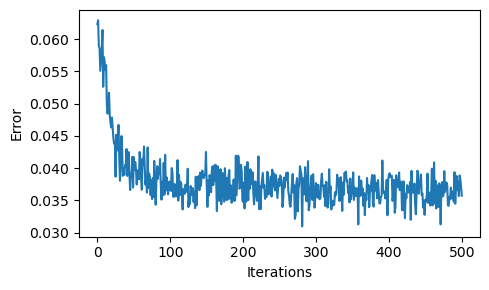

In [7]:
# Plot error
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(error_list)), torch.stack(error_list).cpu())
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:00<00:00, 103.78it/s]


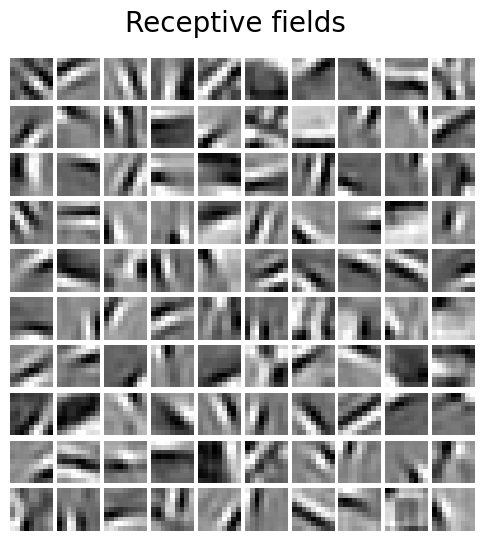

In [8]:
# Plot Receptive fields
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in tqdm.tqdm(range(n_units)):
    plt.subplot(10, 10, i+1)
    plt.imshow(np.reshape(OlshausenNet.Phi[:, i].cpu(), (imgsize, imgsize)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

### ICA Section ###

(128256, 81)


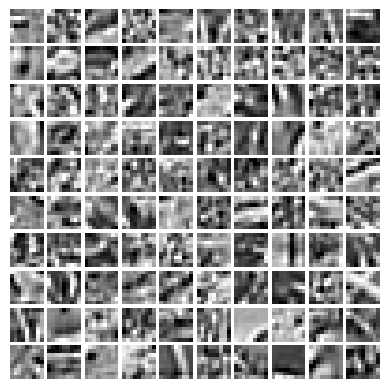

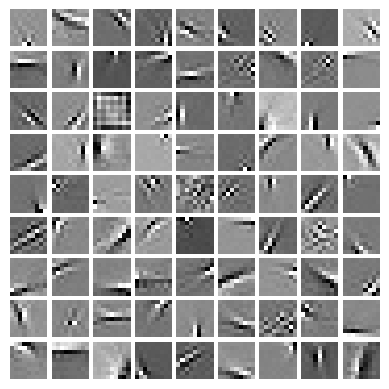

In [9]:
import os



# Set the random seed
# (optional, if stochastic processes are involved we always get the same results)
numx.random.seed(42)

# Load data (download is not existing)
#data = io.load_natural_image_patches('NaturalImage.mat')
# Load data from folder
width = height = 9
data = np.load(r'E:\ICML2026\patches\patches_raw.npy').squeeze().reshape(-1,81)
print(data.shape)

# Specify image width and height for displaying


# Use ZCA to whiten the data and train it
# (you could also use PCA whitened=True + unproject for visualization)
zca = ZCA(input_dim=width * height)
zca.train(data=data)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data = zca.project(data)

# Create a ZCA node and train it (you could also use PCA whitened=True)
ica = ICA(input_dim=width * height)
ica.train(data=whitened_data,
          iterations=100,
          convergence=1.0,
          status=False)

# Show images
images = vis.tile_matrix_rows(matrix=data[0:100].T,
                              tile_width=width,
                              tile_height=height,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches')

# # Show some whitened images
# images = vis.tile_matrix_rows(matrix=whitened_data[0:100].T,
#                               tile_width=width,
#                               tile_height=height,
#                               num_tiles_x=10,
#                               num_tiles_y=10,
#                               border_size=1,
#                               normalized=True)
# vis.imshow_matrix(matrix=images,
#                   windowtitle='First 100 image patches whitened')

# Show the ICA filters/bases
ica_filters = vis.tile_matrix_rows(matrix=ica.projection_matrix,
                                   tile_width=width,
                                   tile_height=height,
                                   num_tiles_x=width,
                                   num_tiles_y=height,
                                   border_size=1,
                                   normalized=True)
vis.imshow_matrix(matrix=ica_filters,
                  windowtitle='Filters learned by ICA')

# # Get the optimal gabor wavelet frequency and angle for the filters
# opt_frq, opt_ang = vis.filter_frequency_and_angle(ica.projection_matrix,
#                                                   num_of_angles=40)

# # Show some tuning curves
# num_filters = 20
# vis.imshow_filter_tuning_curve(ica.projection_matrix[:,0:num_filters],
#                                num_of_ang=40)

# # Show some optima grating
# vis.imshow_filter_optimal_gratings(ica.projection_matrix[:,0:num_filters],
#                                    opt_frq[0:num_filters],
#                                    opt_ang[0:num_filters])

# # Show histograms of frequencies and angles.
# vis.imshow_filter_frequency_angle_histogram(opt_frq=opt_frq,
#                                             opt_ang=opt_ang,
#                                             max_wavelength=14)

# print("log-likelihood on all data: "+str(numx.mean(
#     ica.log_likelihood(data=whitened_data))))

# Show all windows.
vis.show()